In [5]:
from pathlib import Path
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sys.path.append(str(Path.cwd().parents[0] / "src"))

# Notebook at repo root:
sys.path.insert(0, str(Path.cwd() / "src"))
from project_paths import DATA_DIR

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

from functions import visualizations as viz


# reddit_sentiment_august2021.csv

"reddit_sentiment_august2021.csv" is a sentiment analysis of the dataset: \
https://www.kaggle.com/datasets/pavellexyr/reddit-cryptocurrency-data-for-august-2021

There this dataset is called:
- "initial_crypto-aug-2021-comments.csv" 
    - dataset with reddit comments
- "initial_crypto-aug-2021-posts.csv"
    - dataset with reddit posts

#### Dataset columns (description by ChatGPT)
- 'created_utc'
    - The UTC timestamp for when the comment or post was created.
- 'body'
    - The content of the Reddit post or comment related to Bitcoin.
- 'permalink'
    - The link to the specific Reddit post or comment.
- 'comments_sentiment'
    - A general sentiment score for the comment or post.
- 'tb_polarity'
    - The polarity score indicating positivity or negativity derived from TextBlob sentiment analysis.
- 'tb_subjectivity'
    - The subjectivity score indicating the degree of personal opinion derived from TextBlob analysis.
- 'anger'
    - The intensity of anger expressed in the comment or post.
- 'joy'
    - The intensity of joy expressed in the comment or post.
- 'optimism'
    - The intensity of optimism expressed in the comment or post.
- 'sadness'
    - The intensity of sadness expressed in the comment or post.
- 'sia_pos'
    - The positive sentiment score from the VADER sentiment analysis.
- 'sia_neg'
    - The negative sentiment score from the VADER sentiment analysis.
- 'sia_neu'
    - The neutral sentiment score from the VADER sentiment analysis.
- 'sid_com'
    - The compound sentiment score from the VADER sentiment analysis, indicating overall sentiment polarity.
- 'reddit_flair'
    - The flair (label or category) assigned to the post in the specific subreddit, often representing sentiment or topic.
- 'BERT-Sentiment'
    - The sentiment classification result from a BERT-based sentiment analysis model.


In [6]:
reddit_data = pd.read_csv(DATA_DIR / "reddit_sentiment_august2021.csv", index_col='Unnamed: 0')

In [4]:
# reddit_data.columns
# reddit_data.head(1)

#### Dataset analisis

In [5]:
# DataFrame with sentiment analysis results
reddit_data.describe()[['comments_sentiment',
                        'tb_polarity',
                        'tb_subjectivity',
                        'sia_pos',
                        'sia_neg',
                        'sia_neu',
                        'BERT-Sentiment',
                        ]]

,comments_sentiment,tb_polarity,tb_subjectivity,sia_pos,sia_neg,sia_neu,BERT-Sentiment
count,55002.000000,55002.000000,55002.000000,55002.000000,55002.000000,55002.000000,55002.000000
mean,0.092082,0.178669,0.492542,0.190862,0.052493,0.756632,2.271608
std,0.175581,0.157507,0.139313,0.093896,0.056766,0.097903,1.772714
min,-0.969600,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.086517,0.417296,0.132000,0.010000,0.705000,1.000000
50%,0.000000,0.179221,0.495481,0.181000,0.038000,0.761000,1.000000
75%,0.187510,0.263997,0.574486,0.240000,0.076000,0.820000,5.000000
max,0.979100,1.000000,1.000000,1.000000,0.555000,1.000000,5.000000


In [7]:
# Function to plot sentiment columns distributions
def plot_mixed(df, cols, discrete_threshold=10, density=False, xlim_by_col=None, bins="auto"):
    cols = list(cols)
    xlim_by_col = xlim_by_col or {}

    n = len(cols)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axes = np.atleast_1d(axes).ravel()

    for ax, col in zip(axes, cols):
        s = df[col].dropna()
        is_numeric = pd.api.types.is_numeric_dtype(df[col])
        if is_numeric:
            s = pd.to_numeric(s, errors="coerce").dropna()

        is_discrete = (not is_numeric) or (s.nunique() <= discrete_threshold)

        if len(s) == 0:
            ax.set_title(f"{col} (N=0)")
            ax.axis("off")
            continue

        if is_discrete:
            vc = s.astype(str).value_counts().sort_index()
            ax.bar(range(len(vc)), vc.values, alpha=0.8)
            ax.set_xticks(range(len(vc)))
            ax.set_xticklabels(vc.index, rotation=0)
            ax.set_ylabel("Count")
        else:
            ax.hist(s.values, bins=bins, alpha=0.7, edgecolor="white", density=density)
            ax.set_ylabel("Density" if density else "Frequency")
            m, med = float(s.mean()), float(s.median())
            ax.axvline(m, linewidth=1)
            ax.axvline(med, linestyle="--", linewidth=1)
            if col in xlim_by_col:
                ax.set_xlim(*xlim_by_col[col])

        ax.set_title(f"{col} (N={len(s)})")
        ax.set_xlabel(col)
        ax.grid(alpha=0.3)

    for ax in axes[len(cols):]:
        ax.set_visible(False)

    fig.tight_layout()
    return fig, axes


(<Figure size 1800x400 with 3 Axes>,
 array([<Axes: title={'center': 'reddit_flair (N=55002)'}, xlabel='reddit_flair', ylabel='Frequency'>,
        <Axes: title={'center': 'comments_sentiment (N=55002)'}, xlabel='comments_sentiment', ylabel='Frequency'>,
        <Axes: title={'center': 'BERT-Sentiment (N=55002)'}, xlabel='BERT-Sentiment', ylabel='Count'>],
       dtype=object))

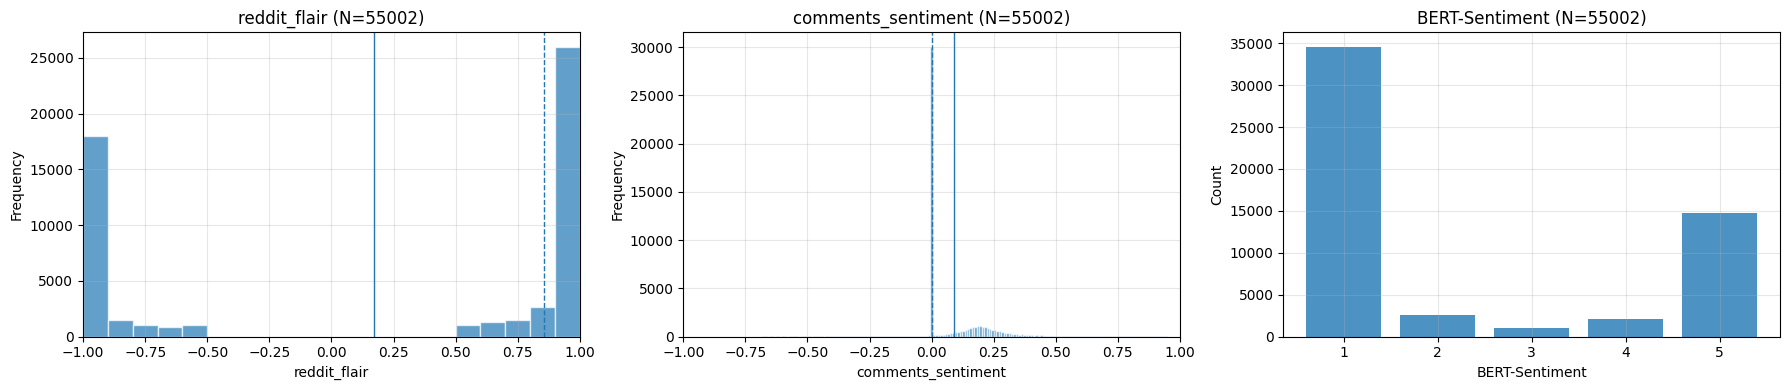

In [9]:
plot_mixed(
    reddit_data,
    ["reddit_flair","comments_sentiment","BERT-Sentiment"],
    xlim_by_col={"reddit_flair": (-1,1), "comments_sentiment": (-1,1)}
)

### BERT-Sentiment column

In [7]:
# Analysis of the 'BERT-Sentiment' column
reddit_data[['BERT-Sentiment']].value_counts(normalize=True)

BERT-Sentiment
1                 0.628686
5                 0.268590
2                 0.046053
4                 0.037853
3                 0.018817
Name: proportion, dtype: float64

In [8]:
BERT_counts = reddit_data['BERT-Sentiment'].value_counts()
BERT_counts.sort_index(inplace=True)
BERT_counts

BERT-Sentiment
1    34579
2     2533
3     1035
4     2082
5    14773
Name: count, dtype: int64

In [9]:
BERT_counts[1] = BERT_counts[1] - (BERT_counts[1] - BERT_counts[5])  
BERT_counts/ BERT_counts.sum()

BERT-Sentiment
1    0.419735
2    0.071968
3    0.029407
4    0.059154
5    0.419735
Name: count, dtype: float64

# reddit_sentiment_processed.csv

In [12]:
# 1) Select columns and create labels 0..4
data = reddit_data[['body', 'BERT-Sentiment']].dropna(subset=['BERT-Sentiment']).copy()
data['BERT-Sentiment'] = pd.to_numeric(data['BERT-Sentiment'], errors='coerce').astype(int)
data['sentiment_label'] = data['BERT-Sentiment'] - 1

# Keep only valid labels 0..4
data = data[data['sentiment_label'].between(0, 4)].reset_index(drop=True)

# 2) Downsample class 0 to match class 4 (if 0 > 4)
vc = data['sentiment_label'].value_counts()
n0 = int(vc.get(0, 0))
n4 = int(vc.get(4, 0))

if n0 > n4 and n4 > 0:
    n_remove = n0 - n4
    drop_idx = (data.index[data['sentiment_label'].eq(0)]
                .to_series()
                .sample(n=n_remove, replace=False, random_state=42)
                .index)
    data = data.drop(drop_idx).reset_index(drop=True)

# 3) Final labels array
labels = data['sentiment_label'].to_numpy()

# 4) Save the processed data
data.to_csv(DATA_DIR / "reddit_sentiment_processed.csv", index=False)